In [1]:
from casadi import *
import numpy as np
from matplotlib import pyplot as plt
import time
import os
import sys
%matplotlib inline

In [2]:
os.environ["OMP_NUM_THREADS"] = "7"
os.environ["WORHP"] = "/usr/lib"
os.environ["WORHP_LICENSE_FILE"] = "/home/jovyan/thesis/worhp.lic"

In [3]:
# Misc. constants
nx = 3 # state-space dimension
nu = 3 # control dimension

In [4]:
# state-space equation
def create_f(x, u, x_init, L1):
    theta_g = atan2(u[1] - x_init[1], u[0] - x_init[0])
    
    V = u[2]
    
    lat = x[0]
    lng = x[1]
    th = x[2]
    lat_dot = V*sin(th)
    lng_dot = V*cos(th)
    
    d = -lat*sin(theta_g) + lng*cos(theta_g)
    d_dot = -lat_dot*sin(theta_g) + lng_dot*cos(theta_g)
    
    th_dot = 2/L1*(d_dot + V/L1*d)
    
    Q = lat_dot**2 + lng_dot**2#sqrt(1 + (lng_dot/fmax(lat_dot, 0.0001))**2)
    
    return Function(
        'f',
        [x, u],
        [vertcat(lat_dot, lng_dot, th_dot), Q],
        ['x', 'u'],
        ['xdot', 'Q']
    )
    

In [5]:
def sim_seq(U, X_init=np.array([0, 0, 0]), L1=0.3, wp_R=0.05, dt=1):
    X_sim = np.zeros((nx, 1))
    X_sim[:, 0] = X_init
    for i in range(len(U)):
        X_start = X_sim[:, -1]
        f_sim = create_f(MX.sym('x', nx), MX.sym('u', nu), X_start[:2], L1)
        Uk = U[i]
        j = 0
        while True:
            # RK4 integration
            k1, _ = f_sim(X_sim[:, -1], Uk)
            k2, _ = f_sim(X_sim[:, -1]+dt/2*k1, Uk)
            k3, _ = f_sim(X_sim[:, -1]+dt/2*k2, Uk)
            k4, _ = f_sim(X_sim[:, -1]+dt*k3, Uk)
            
            Xk = X_sim[:, -1] + dt/6*(k1+k2+k3+k4)

            X_sim = np.append(X_sim, Xk, axis=1)
                       
            rx = Xk[:2] - X_start[:2]
            ru = Uk[:2] - X_start[:2]
            rx = np.array(rx).flatten()
            
            if np.linalg.norm(rx-ru) < wp_R:
                print('wp reached in {} iterations, R'.format(j+1))
                break 

            if np.dot(rx, ru)/(np.linalg.norm(ru)**2) > 1:
                print('wp reached in {} iterations, passed'.format(j+1))
                break
            j += 1
    return X_sim

In [6]:
def get_dist(X, N):
    d = 0
    for i in range(1, N):
        d += np.linalg.norm(X[:2, i] - X[:2, i-1])
    return d

In [7]:
def gen_init(Xg, nIt, n_c):
    X_init = np.zeros((nIt, nx, n_c))
    U_init = np.zeros((nIt, nu))
    T_init = np.zeros(nIt)
    
    x = np.linspace(0, Xg[0], nIt+1)
    y = np.linspace(0, Xg[1], nIt+1)
    th = np.linspace(0, Xg[2], nIt+1)
    
    for i in range(nIt):
        X_init[i, :] = np.vstack((
            np.linspace(x[i], x[i+1], n_c),
            np.linspace(y[i], y[i+1], n_c),
            np.linspace(th[i], th[i+1], n_c)
        ))
        U_init[i, 0] = x[i+1]
        U_init[i, 1] = y[i+1]
        T_init[i] = np.linalg.norm(X_init[i, :2, -1] - X_init[i, :2, 0])
    return X_init, U_init, T_init

In [8]:
def gen_init_sim(X_sim, N_i, nIt, n_c):
    X_init = np.zeros((nIt, nx, n_c))
    U_init = np.zeros((nIt, nu))
    T_init = np.zeros(nIt)
    N_init = []
    k = int(ceil(N_i/nIt))
    for i in range(nIt):
        start = i * k
        end = min((i+1) * k, N_i)
        X_init[i, 0, :] = np.linspace(X_sim[0, start], X_sim[0, end], n_c)
        X_init[i, 1, :] = np.linspace(X_sim[1, start], X_sim[1, end], n_c)
        X_init[i, 2, :] = np.linspace(X_sim[2, start], X_sim[2, end], n_c)
        U_init[i, :2] = X_sim[:2, end]
        T_init[i] = get_dist(X_sim[:2, start:end], end-start)
        N_init += [end-start]
        
    return X_init, U_init, T_init, N_init

In [9]:
default_opts = {
    'Xs': np.array([0.0, 0.0, 0]),
    'Xg': [1, 0, np.pi/2],
    'X_min': [-2, -2],
    'X_max': [2, 2],
    'V_init': 0.03,
    'V_min': 0.075,
    'V_max': 0.2,
    'L1': 0.3,
    'wp_R': 0.01,
    'p_dist': 0.8,
    'nIt': 1,
    'n_c': 15,
    'd': 3,
    'terminal': 'heading', # heading | parallell | fixed
    'solver': 'ipopt'
}

class MotionPrimitive:
    
    def __init__(self, **kwargs):
        self.opts = default_opts
        for key, val in kwargs.items():
            if key in default_opts:
                self.opts[key] = val
        self.opti = casadi.Opti()
        self.X=[]
        self.Xc=[]
        self.U=[]
        self.T=[]
        
    def sim(self, gen_init=True, plot=False):
        Xg = self.opts['Xg']
        V_init = self.opts['V_init']
        X_sim = sim_seq([np.array([Xg[0], Xg[1], V_init])])
        self.X_sim = X_sim
        self.N_sim = X_sim.shape[1]-1
        if gen_init:
            nIt = self.opts['nIt']
            n_c = self.opts['n_c']
            self.X_init, self.U_init, self.T_init, _ = gen_init_sim(
                self.X_sim,
                self.N_sim,
                nIt,
                n_c,
            )
        if plot:
            plt.quiver(X_sim[0,:], X_sim[1,:], sin(X_sim[2,:]), cos(X_sim[2,:]))
            plt.grid(True)
            plt.axis('equal')
            plt.show()
            
    def setup(self):
        d = self.opts['d']
        nIt = self.opts['nIt']
        n_c = self.opts['n_c']
        
        # create collocation points
        tau_root = np.append(0, collocation_points(d, 'legendre'))

        # Coefficients of the collocation equation
        C = np.zeros((d+1,d+1))

        # Coefficients of the continuity equation
        D = np.zeros(d+1)
        
        B = np.zeros(d+1)

        # Construct polynomial basis
        for j in range(d+1):
            # Construct Lagrange polynomials to get the polynomial basis at the collocation point
            p = np.poly1d([1])
            for r in range(d+1):
                if r != j:
                    p *= np.poly1d([1, -tau_root[r]]) / (tau_root[j]-tau_root[r])

            # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
            D[j] = p(1.0)

            # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
            pder = np.polyder(p)
            for r in range(d+1):
                C[j,r] = pder(tau_root[r])
                
            pint = np.polyint(p)
            B[j] = pint(1.0)
        
        # setup optimization problem
        L1 = self.opts['L1']
        self.J = 0
        for i in range(nIt):
            X_i = self.opti.variable(nx, n_c)
            U_i = self.opti.variable(nu)
            T_i = self.opti.variable()

            if i == 0:
                f = create_f(X_i, U_i, [0, 0], L1)
            else:
                f = create_f(X_i, U_i, self.U[i-1][:2], L1)

            for k in range(n_c-1):
                dt = T_i/(n_c-1)
                Xc_k = []
                for j in range(d):
                    Xkj = self.opti.variable(nx)
                    Xc_k += [Xkj]

                x_next = D[0]*X_i[:, k]

                for j in range(1,d+1):
                    # Expression for the state derivative at the collocation point
                    xp = C[0,j]*X_i[:, k]
                    for r in range(d):
                        xp = xp + C[r+1,j]*Xc_k[r]

                    # Append collocation equations
                    fj, qj = f(Xc_k[j-1], U_i)
                    self.opti.subject_to( dt*fj == xp )

                    # Add contribution to the end state
                    x_next = x_next + D[j]*Xc_k[j-1]
                    
                    # Add contribution to quadrature
                    self.J += B[j]*qj*dt
                    
                self.opti.subject_to( X_i[:, k+1] == x_next )
                for _x in Xc_k:
                    self.Xc += [_x]


            # state constraints
            X_min = self.opts['X_min']
            X_max = self.opts['X_max']
            wp_R = self.opts['wp_R']

            x = X_i[0,:]
            y = X_i[1,:]
            th = X_i[2, :]
            self.opti.subject_to(self.opti.bounded(X_min[0], x, X_max[0]))
            self.opti.subject_to(self.opti.bounded(X_min[1], y, X_max[1]))

            # control constraints
            V_min = self.opts['V_min']
            V_max = self.opts['V_max']
            un_x = U_i[0]
            un_y = U_i[1]
            self.opti.subject_to(self.opti.bounded(X_min[0], un_x, X_max[0]))
            self.opti.subject_to(self.opti.bounded(X_min[1], un_y, X_max[1]))

            # add small epsilon to avoid division by zero
            self.opti.subject_to( np.sqrt((X_i[0, -1]-un_x)**2+(X_i[1, -1]-un_y)**2 + 0.0001) <= wp_R )

            V_i = U_i[2]
            self.opti.subject_to(self.opti.bounded(V_min, V_i, V_max ))

            # misc constraints
            self.opti.subject_to(T_i >= 0.0)

            # trajectory constraints
            Xs = self.opts['Xs']
            Xg = self.opts['Xg']
            terminal = self.opts['terminal']
            if i == 0:
                self.opti.subject_to(X_i[:,0] == Xs)
            else:
                self.opti.subject_to( X_i[:,0] == self.X[i-1][:,-1])        

            if i == nIt - 1:
                if terminal == 'heading':
                    self.opti.subject_to(X_i[2,-1] == Xg[2])
                elif terminal == 'parallell':
                    p_dist = self.opts['p_dist']
                    self.opti.subject_to(X_i[0, -1] >= p_dist)
                    self.opti.subject_to(X_i[2, -1] == 0.0)
                elif terminal == 'fixed':
                    self.opti.subject_to(X_i[:2, -1] == Xg[:2])
                    self.opti.subject_to(self.opti.bounded(Xg[2] - 0.05, X_i[2, -1],Xg[2] + 0.05))

            self.X += [X_i]
            self.U += [U_i]
            self.T += [T_i]
            
        objective = 0
        for i in range(nIt):
            objective += self.T[i]
            self.opti.set_initial(self.T[i], self.T_init[i])
            self.opti.set_initial(self.X[i], self.X_init[i])
            self.opti.set_initial(self.U[i], self.U_init[i])
        self.opti.minimize(self.J)
        
    def solve(self):
        solver = self.opts["solver"]

        if solver == "ipopt":
            p_opts  ={"expand": True, "print_time" : False }
            s_opts = {"linear_solver": "ma57", "max_iter" : 10000, "print_level" : 5, "mu_init" : 0.1, "tol": 1e-5, "print_level": 0 }
        elif solver == "sqpmethod":
            s_opts = {"print_iter": False, "print_header" : False}
            p_opts = {"expand": True, "qpsol" : "qrqp", "qpsol_options" : s_opts, "print_iteration" : True, "print_header" : False, "print_status" : False}
        elif solver == "worhp" :
            p_opts  ={"expand": True, "print_time" : False }
            s_opts = {"MaxIter": 500,"NLPprint": 2, "BFGSmethod" : 3, "LineSearchMethod": 1, "RegStrategy": 3, "SwitchMode": 0, "RefineFeasibility": 0,  "RefineFeasTermination": 1, "RefineContrLimitq": 10**-6, "RefineContrLimitc": 8*10**-4}
        
        self.opti.solver(solver, p_opts, s_opts)
        self.opti.solve()
        
    def plot_initial(self):
        nIt = self.opts['nIt']
        print(nIt)
        for i in range(nIt):
            x = self.opti.debug.value(self.X[i], self.opti.initial())
            u = self.opti.debug.value(self.U[i], self.opti.initial())
            print(u)
            plt.quiver(x[0], x[1], sin(x[2]), cos(x[2]), color='green', pivot='mid')
            plt.scatter(u[0], u[1], color='red')
        plt.show()
            
        
    def plot_solution(self, sim=True, collocation=True):
        if sim:
            dt = np.max([np.min([self.opti.value(t) for t in self.T])/50, 0.01])
            wp_R = self.opts['wp_R']
            X_sim = sim_seq(
                list(filter(lambda u: np.linalg.norm(u[:2]) > wp_R, [self.opti.debug.value(u) for u in self.U])),
                wp_R=wp_R,
                dt=dt
            )
            plt.quiver(X_sim[0, :], X_sim[1, :], sin(X_sim[2, :]), cos(X_sim[2, :]), color='black', pivot='mid', alpha=0.5)
            
        if collocation:
            for _, Xck in enumerate(self.Xc):
                x = self.opti.debug.value(Xck)
                plt.quiver(x[0], x[1], sin(x[2]), cos(x[2]), color='blue', alpha=.3)
        
        nIt = self.opts['nIt']
        for i in range(nIt):
            x = self.opti.debug.value(self.X[i])
            u = self.opti.debug.value(self.U[i])
            plt.quiver(x[0], x[1], sin(x[2]), cos(x[2]), color='green', pivot='mid')
            plt.scatter(u[0], u[1], color='red', s=100)
        plt.axis('equal')
        plt.show()       

wp reached in 70 iterations, R


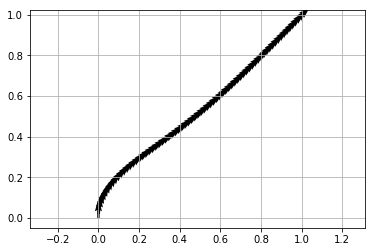


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

wp reached in 75 iterations, R


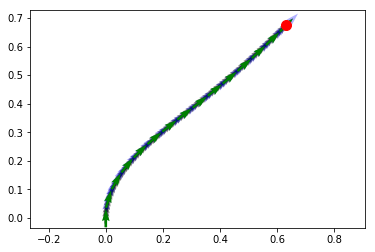

In [10]:
mp = MotionPrimitive(Xg=np.array([1, 1, np.pi/4]))
mp.sim(plot=True)
mp.setup()
mp.solve()
mp.plot_solution()

wp reached in 53 iterations, R


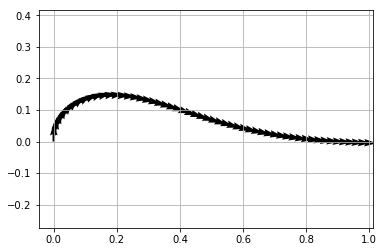

wp reached in 74 iterations, R


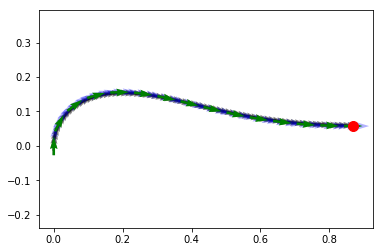

In [11]:
mp = MotionPrimitive(Xg=np.array([1, 0, np.pi/2]))
mp.sim(plot=True)
mp.setup()
mp.solve()
mp.plot_solution()

wp reached in 81 iterations, R


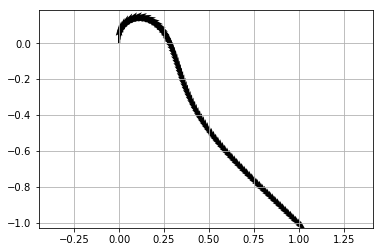

wp reached in 74 iterations, R


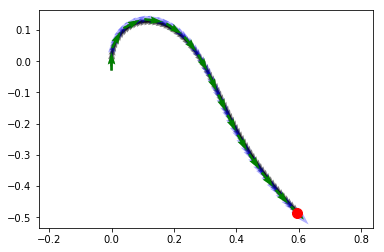

In [12]:
mp = MotionPrimitive(Xg=np.array([1, -1, 3*np.pi/4]))
mp.sim(plot=True)
mp.setup()
mp.solve()
mp.plot_solution()

wp reached in 81 iterations, R


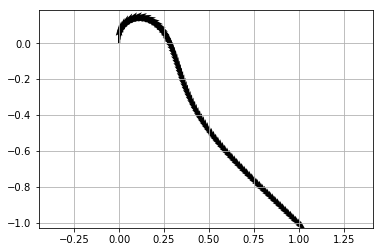

wp reached in 73 iterations, R


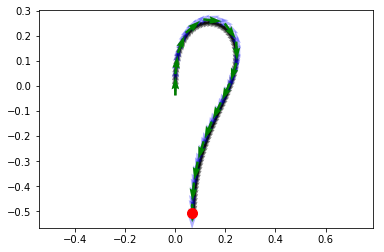

In [13]:
mp = MotionPrimitive(Xg=np.array([1, -1, np.pi]))
mp.sim(plot=True)
mp.setup()
mp.solve()
mp.plot_solution()

wp reached in 19 iterations, passed


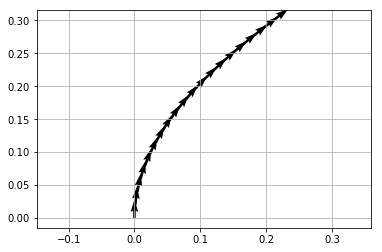

wp reached in 713 iterations, R
wp reached in 74 iterations, R


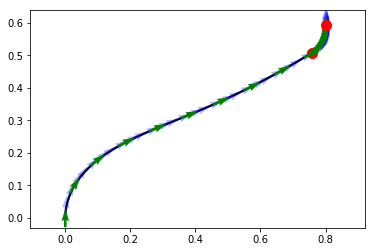

In [14]:
mp = MotionPrimitive(
    Xg=np.array([0.25, 0.25, 0*np.pi/2]),
    terminal='parallell',
    nIt=2,
    n_c=10,
    p_dist=0.8
)
mp.sim(plot=True)
mp.setup()
mp.solve()
mp.plot_solution()

wp reached in 50 iterations, R


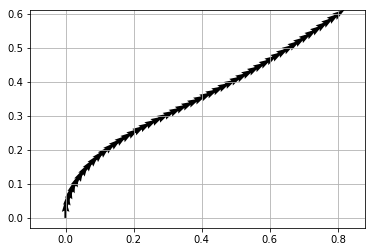

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:943: Assertion "return_success()" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

In [16]:
mp = MotionPrimitive(
    Xg=np.array([.8, .6, np.pi/2]),
    terminal='fixed',
    nIt=3,
    n_c=10
)
mp.sim(plot=True)
mp.setup()
mp.solve()
mp.plot_solution()

wp reached in 1419 iterations, R
wp reached in 120 iterations, R


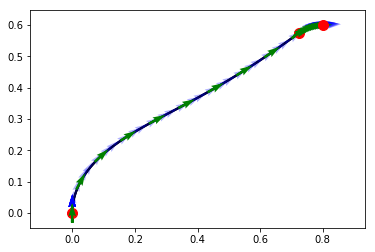

In [17]:
mp.plot_solution()